# What is Recommendation Systems ?

Acording to [wikipedia](https://en.wikipedia.org/wiki/Recommender_system#:~:text=A%20recommender%20system%2C%20or%20a,would%20give%20to%20an%20item.) : A  recommendation system , is a subclass of information filtering system that seeks to predict the "rating" or "preference" a user would give to an item.They are primarily used in commercial applications.

Recommendation systems are utilized in a variety of areas and are most commonly recognized as playlist generators for video and music services like Netflix, YouTube and Spotify, product recommenders for services such as Amazon, or content recommenders for social media platforms such as Facebook and Twitter.These systems can operate using a single input, like music, or multiple inputs within and across platforms like news, books, and search queries. There are also popular recommender systems for specific topics like restaurants and online dating. Recommender systems have also been developed to explore research articles and experts,collaborators,and financial services

There are basically three types of recommender systems:

* Content based recommendation engine
* Popularity based recommendation engine or Demographic Filtering
* Collaborative filtering based recommendation engine

Let's understand the differences between different recommendation engines

**Content based recommendation engine:**
This type of recommendation systems, takes in a movie that a user currently likes as input. Then it analyzes the contents (storyline, genre, cast, director etc.) of the movie to find out other movies which have similar content. Then it ranks similar movies according to their similarity scores and recommends the most relevant movies to the user

**Popularity based recommendation engine:**
This is the simplest kind of recommendation engine that you will come across. The trending list you see in YouTube or Netflix is based on this algorithm. It keeps a track of view counts for each movie/video and then lists movies based on views in descending order(highest view count to lowest view count).
They offer generalized recommendations to every user, based on movie popularity and/or genre. The System recommends the same movies to users with similar demographic features. Since each user is different , this approach is considered to be too simple. The basic idea behind this system is that movies that are more popular and critically acclaimed will have a higher probability of being liked by the average audience

**Collaborative filtering based recommendation engine:**
This algorithm at first tries to find similar users based on their activities and preferences (for example, both the users watch same type of movies or movies directed by the same director). Now, between these users(say, A and B) if user A has seen a movie that user B has not seen yet, then that movie gets recommended to user B and vice-versa. In other words, the recommendations get filtered based on the collaboration between similar user’s preferences (thus, the name “Collaborative Filtering”). One typical application of this algorithm can be seen in the Amazon e-commerce platform, where you get to see the “Customers who viewed this item also viewed” and “Customers who bought this item also bought” list.

We will start with **Contet Based Recommendation Engine**

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Data Extraction and Cleansing

In [ ]:
df1=pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_movies.csv')
df2=pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_credits.csv')
print("Importing the data sets and verifying the columns")

Verifying columns and top five records from both data sets

In [ ]:
df1.head()

In [ ]:
df2.head()

For further analysis let's add 'cast' and 'crew' columns from second to first data frame

In [ ]:
#Adding 'cast' column to first data frame
df1['cast']=df2['cast']
df1['crew']=df2['crew']

In [ ]:
#Verifying added columns in data frame
df1.columns

For cotent based recommendation engine we need to get metadata about a movie , which we can get from 'keywords' , 'cast' ,'crew' and 'genres' columns.

Let's pull out these columns as 'features'

In [ ]:
features=['keywords','cast','crew','genres']

These columns consist of following attributes and not all attributes are required for creating metadata 

**Keywords** : 
1. id
2. name

**Cast** :
1. cast_id
2. character
3. credit_id
4. gender
5. id
6. name
7. order

**Crews** :
1. credit_id
2. department
3. gender
4. id
5. job
6. name
 
**Genres** :
1. id
2. name

We can drop all numerical/identifer attributes from all four columns. 
In 'Crew' we can only keep name of **'Director'** from 'department' attribute.Similarly , in 'Cast' ,'keywords' and 'Genres' we can only keep **'name'** attribute

Now , we will create a funciton to fetch Director's name  and top 3 elements present in name atribute from 'Cast' , 'Keyword' and 'Genres' columns for each movie

In [ ]:
# Parse the stringified features into their corresponding python objects
from ast import literal_eval

for feature in features:
    df1[feature] = df1[feature].apply(literal_eval)

In [ ]:
#Fetching director's name from the crew feature , if not listed then return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

#Return list top 3 elements or entire list , which ever is more
def get_list(x):
    if isinstance(x,list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names=names[:3]
        return names
    #Return empty list in case of missing/malformed data
    return []

Appyling this function to each row of data set and displaying the data frame

In [ ]:
#Apply get_director function to 'crew' feature
df1['director'] = df1['crew'].apply(get_director)
#defining list of feature again to apply get_list function
features = ['cast', 'keywords', 'genres']
for feature in features:
    df1[feature] = df1[feature].apply(get_list)

In [ ]:
df1[['title','director','keywords','cast','genres']]

The next step would be to convert the names and keyword instances into lowercase and strip all the spaces between them. 

This is required so that our vectorizer doesn't count the Johnny of "Johnny Depp" and "Johnny Galecki" as the same.

In [ ]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [ ]:
#Apply clean_data function to our features
features = ['cast', 'keywords', 'genres','director']

for feature in features:
    df1[feature]=df1[feature].apply(clean_data)


Verifying the clean up data

In [ ]:
df1[['title','director','keywords','cast','genres']]

We can create combine features function now , which will be a string that contains all metadata(Keywords,Cast,Director and Genres) about movie that we want to feed our vectorizer

In [ ]:
def combine_features(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])

df1['combine_feature'] = df1.apply(combine_features,axis=1)

In [ ]:
df1[['title','combine_feature']]

# Building the Recommendation Engine


Now that we have obtained the combined feature/string, we can now feed these strings to a CountVectorizer() object for getting the count matrix and getting Cosine Similarity.

Before going further let's understand the concept behind cosine similarity and how it is related to Content Based Recommendation Engine.

In this type of recommendation engine we need to find similar movies to a given movie and then recommend those similar movies to the user. The logic is pretty straightforward but the bigger question is how can we find out which movies are similar to the given movie in the first place? How can we find out how much similar(or dissimilar) two movies are?

Let us start with something simple and easy to understand. 

Suppose, you are given the following two texts:

Text A: London Paris London

Text B: Paris Paris London

How would you find the similarity between Text A and Text B?

Let’s analyze these texts….

Text A: Contains the word “London” 2 times and the word “Paris” 1 time.
Text B: Contains the word “London” 1 time and the word “Paris” 2 times.
Now, what will happen if we try to represent these two texts in a 2D plane (with “London” in X axis and “Paris” in Y axis)? Let’s try to do this.

It will look like this-

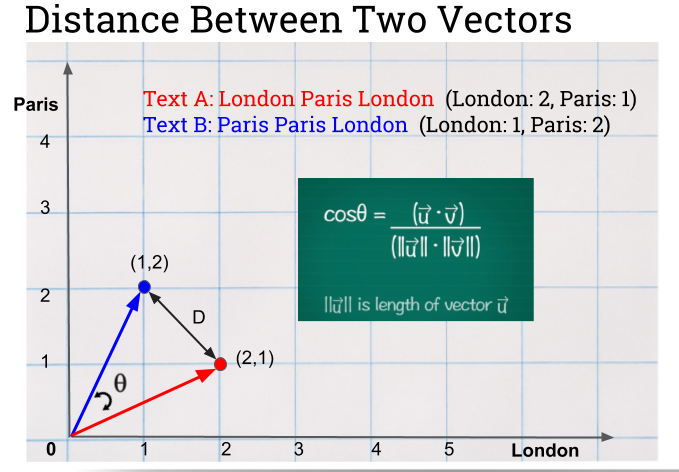

Here, the red vector represents “Text A” and the blue vector represents “Text B”.

Now we have graphically represented these two texts in another words we can say that these two texts are represented as vectors.So, we can say that two vectors are similar if the distance between them is small. By distance, we mean the angular distance between two vectors, which is represented by θ (theta). By thinking further from the machine learning perspective, we can understand that the value of cos θ makes more sense to us rather than the value of θ (theta) because, the cosine(or “cos”) function will map the value of θ in the first quadrant between 0 to 1 (Remember? cos 90° = 0 and cos 0° = 1 ).

And from high school maths, we can remember that there is actually a formula for finding out cos θ between two vectors. 

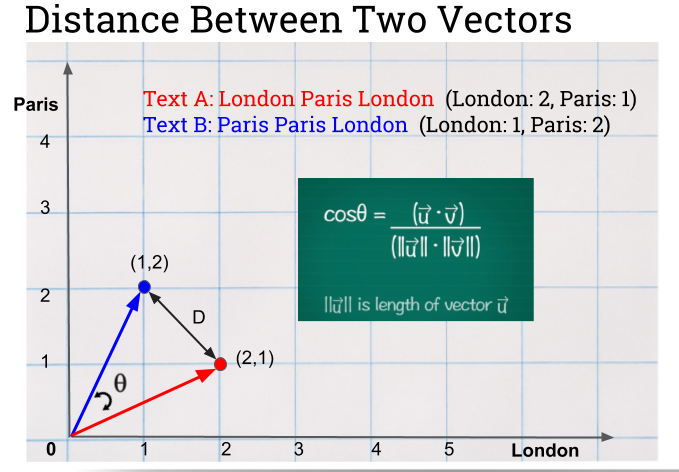


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
print("Importing Sckit learn libraries for calculating Cosine Similarity")

In [ ]:
cv = CountVectorizer(stop_words='english') #creating new CountVectorizer() object
count_matrix = cv.fit_transform(df1["combine_feature"]) #feeding combined strings(movie contents) to CountVectorizer() object
cosine_sim = cosine_similarity(count_matrix,count_matrix)

In [ ]:
# Reset index of our main DataFrame
df1 = df1.reset_index()
indices = pd.Series(df1.index, index=df1['title'])

We will write get_recommendation function to get recommended movie . This recomendation function will perform following actions

* Get the index of the movie given its title.
* Get the list of cosine similarity scores for that particular movie with all movies. Convert it into a list of tuples where the first element is its position and the second is the similarity score.
* Sort the aforementioned list of tuples based on the similarity scores; that is, the second element.
* Get the top 10 elements of this list. Ignore the first element as it refers to self (the movie most similar to a particular movie is the movie itself).
* Return the titles corresponding to the indices of the top elements.

In [ ]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df1['title'].iloc[movie_indices]

Now , we are done with all coding  let's call recommendation engine fucntion to get similar movies

In [ ]:
get_recommendations('The Dark Knight Rises', cosine_sim)

In [ ]:
get_recommendations('Avatar', cosine_sim)

In [ ]:
get_recommendations('The Godfather', cosine_sim)

We can see that our recommender has been successful recommendending similar movies , it can be further improved by adding multiple features in movie metadata

# Resources

* https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system
* https://github.com/codeheroku/Introduction-to-Machine-Learning/tree/master/Building%20a%20Movie%20Recommendation%20Engine
